# Recent Surveys

This notebook evaluates the most recent surveys and is a benchmark to see how good we can predict consumption using the public available data.

In [1]:
cd ..

/home/sallinen/Programmation/predicting-poverty-through-time/src


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from lib import estimator_util as eu
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

/home/sallinen/miniconda3/envs/predicting-poverty-through-time/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
sns.set_theme()

In [5]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=1)
_ = pca.fit(complete_df[all_cols])
features_weights = list(zip(all_cols, pca.components_.T))

## Get names of useless OSM features for the 4 countries

In [7]:
countries = ["NG", "ETH" ,"TZA", "MW"]
X, _, _, _ = eu.get_recent_osm_features(complete_df, countries, all_cols)
X = pd.DataFrame(X, columns=all_cols)
null_features = X.loc[:, (X == 0).any(axis=0)].keys()

## Predict r^2 for every country in our dataset.

In [8]:
def cnn_osm(complete, model_, params = None):
    countries = ["NG", "ETH" ,"TZA", "MW"]
    all_trained_models = []
    for i, country in enumerate(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model_, seed=1, **(params[i]))
        fig = eu.plot_predictions(y_real, y_predicted, r2, country, year, i)
        fig.savefig(f"../figs/{country}_{year}_cnnosm_{model_}.pdf", dpi=600)
        all_trained_models.append(trained_model)
    return all_trained_models

def cnn_osm2(complete, model_, country, **params):
    tmp_df = complete.loc[complete.country == country]
    years = tmp_df.groupby(["year"]).groups.keys()
    year = max(years)
    X, y = eu.get_recent_features(tmp_df, [country], all_cols, null_osm_features=null_features)
    r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model_, seed=1, **params)
    fig = eu.plot_predictions(y_real, y_predicted, r2, country, year)
    fig.savefig(f"../figs/{country}_{year}_cnnosm_{model_.__name__}.pdf", dpi=600)
    return trained_model

In [9]:
cnn_osm(complete_df, Ridge, [{'alpha' : 1000}]*4)

TypeError: '<' not supported between instances of 'list' and 'int'

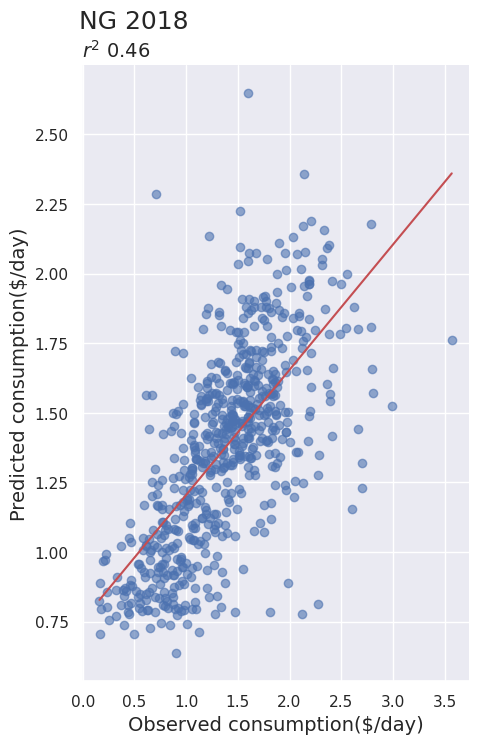

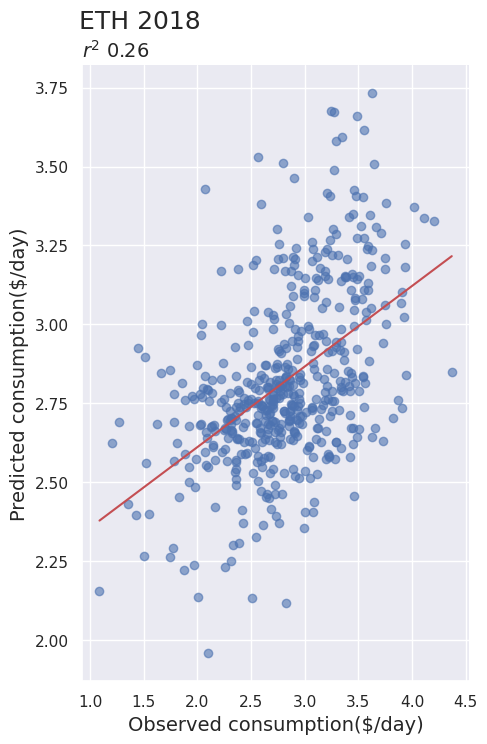

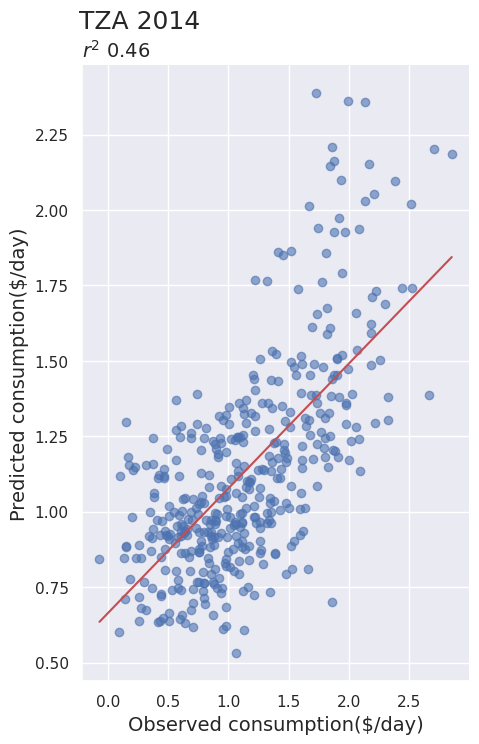

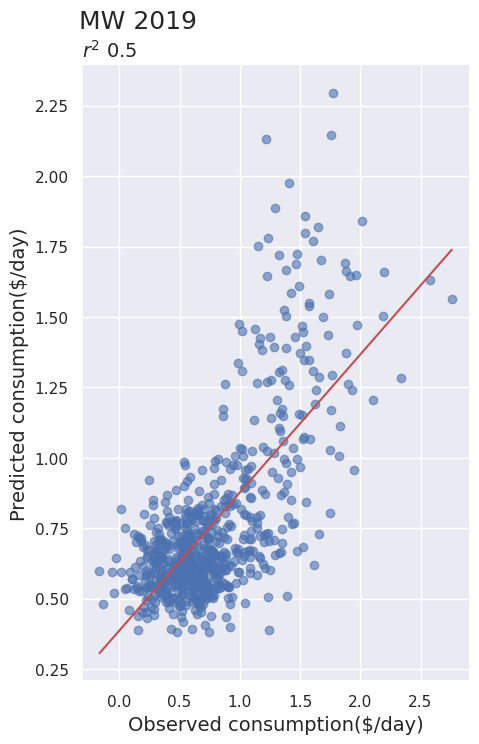

In [10]:
for country in countries:
    cnn_osm2(complete_df, Ridge, country, alpha = 1000)

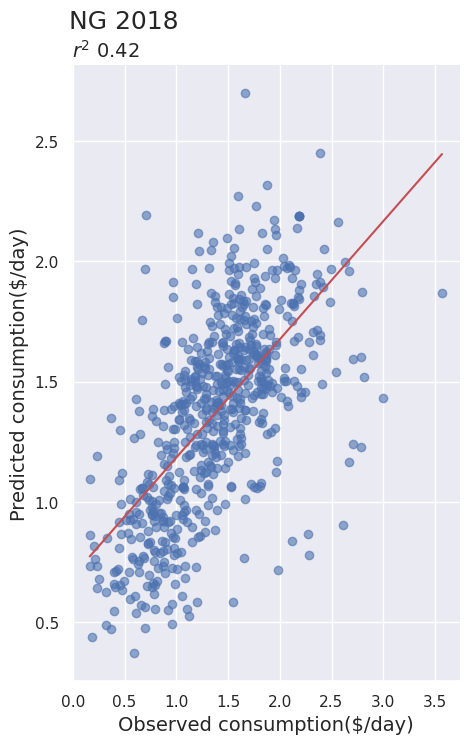

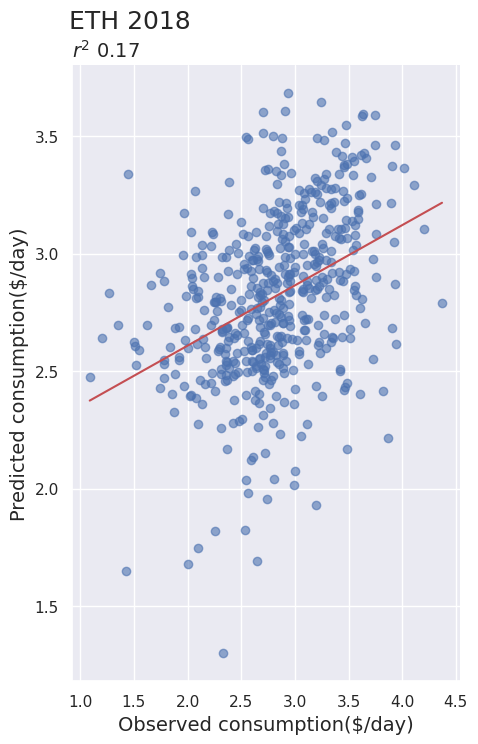

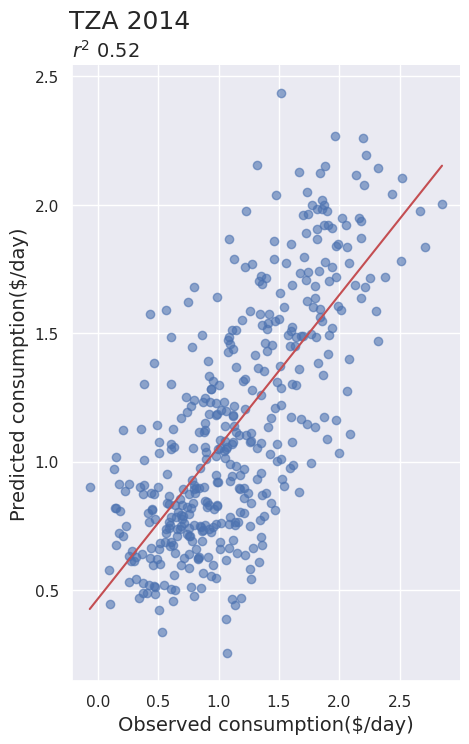

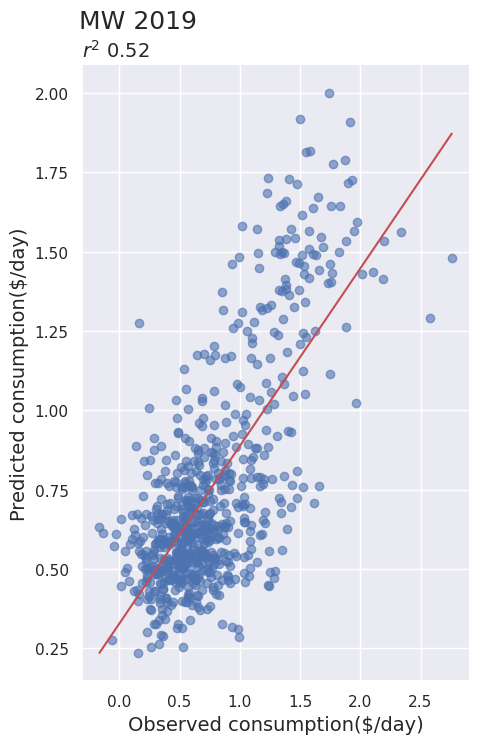

In [11]:
for country in countries:
    cnn_osm2(complete_df, XGBRegressor, country)

In [13]:
complete_df

,id,building_count,building_area,building_density,residential_count,residential_area,residential_density,industry_count,industry_area,industry_density,...,density_track,density_tertiary,country,year,lat,lon,cons_pc,rural,features,nightlight
0,ETH_2013_0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,ETH,2013,3.455701,39.515995,7.433890,rural,"[1.6279486417770386, 0.8304390907287598, 0.100...",4.121094
1,ETH_2013_1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,ETH,2013,3.549937,39.184235,6.183653,rural,"[0.9503694176673889, 0.5384379029273987, 0.246...",4.040159
2,ETH_2013_10,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,ETH,2013,5.213502,40.035152,8.593643,rural,"[0.9371468424797058, 0.21409447491168976, 0.39...",4.096999
3,ETH_2013_100,0.0,0.0,0.0,1.0,5478445.44,124051.76,0.0,0.0,0.0,...,0.00,174.42,ETH,2013,7.190572,35.422832,7.953994,rural,"[0.26513218879699707, 1.8752188682556152, 1.53...",5.095783
4,ETH_2013_101,1.0,0.0,0.0,6.0,16130415.89,365303.78,0.0,0.0,0.0,...,388.35,4.28,ETH,2013,7.223887,38.602867,8.509425,urban,"[0.9147024154663086, 0.4539594054222107, 0.140...",13.040518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,TZA_2014_95,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,268.20,278.03,TZA,2014,-6.912678,39.150288,4.951838,urban,"[1.3091425895690918, 1.0642071962356567, 2.379...",3.287821
6997,TZA_2014_96,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,TZA,2014,-6.911376,39.251190,5.159592,urban,"[1.8155121803283691, 1.2647819519042969, 1.896...",6.671783
6998,TZA_2014_97,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,TZA,2014,-6.908106,39.264687,4.422887,urban,"[1.3355880975723267, 1.3461166620254517, 1.219...",7.012608
6999,TZA_2014_98,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.00,0.00,TZA,2014,-6.904070,39.285221,7.499683,urban,"[0.8180636763572693, 1.3184998035430908, 1.159...",5.824744


In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from lib import clusters_utils as cl


def optimize_params(complete, model_, params, seed, doPlot=False):
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)

    countries = ["NG", "ETH", "TZA", "MW"]
    best_params = {"NG":{}, "ETH": {}, "TZA": {}, "MW": {}}
    for country in tqdm(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        recent_df_complete = tmp_df.loc[tmp_df.year == year]
        split_map = cl.split_k_sets(10, lat=recent_df_complete["lat"], lon=recent_df_complete["lon"])
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        search = GridSearchCV(model_, param_grid=params, scoring='r2', cv=cl.folds_from_split(split_map))
        result = search.fit(X, y)
        for key in params:
            if doPlot:
                plt.plot(params[key], result.cv_results_['mean_test_score'], label=country)
                plt.xlabel(key)
                plt.ylabel('r2')
                plt.legend()

            best_params[country].update({key : result.best_params_[key]})

    return best_params


best_params = optimize_params(complete_df, Ridge(), params={'alpha': np.linspace(500, 5000, num=100)}, seed=1)
max_depth = [2,4]
n_estimators = [50,100]
#best_params = optimize_params(complete_df, XGBRegressor(), params={'max_depth': max_depth, 'n_estimators': n_estimators}, seed=1)

print(best_params)

100%|██████████| 4/4 [00:22<00:00,  5.57s/it]

{'NG': {'alpha': 1045.4545454545455}, 'ETH': {'alpha': 1772.7272727272727}, 'TZA': {'alpha': 500.0}, 'MW': {'alpha': 1409.090909090909}}


100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


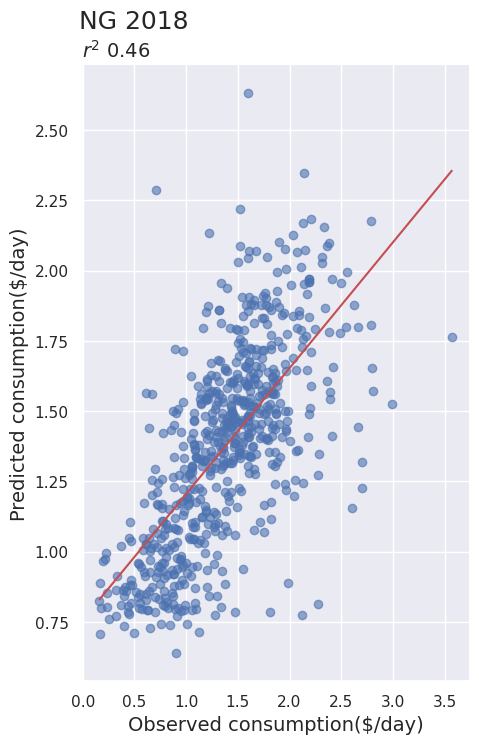

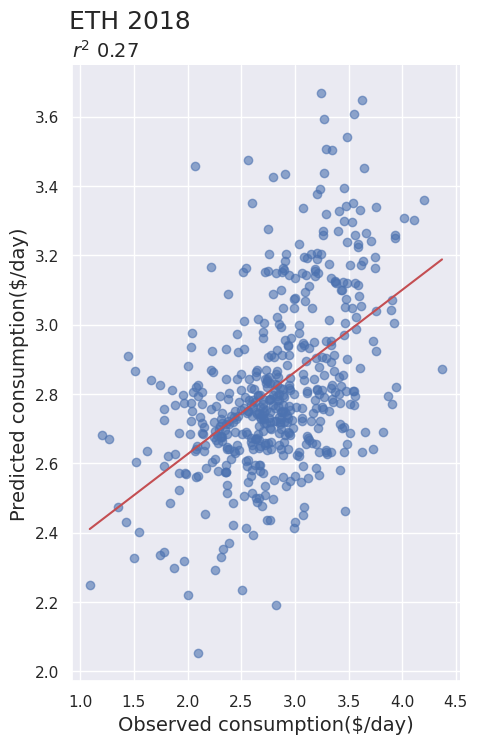

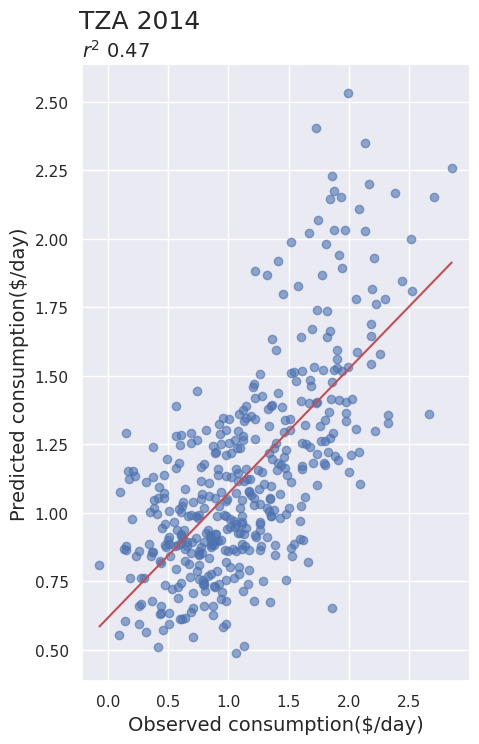

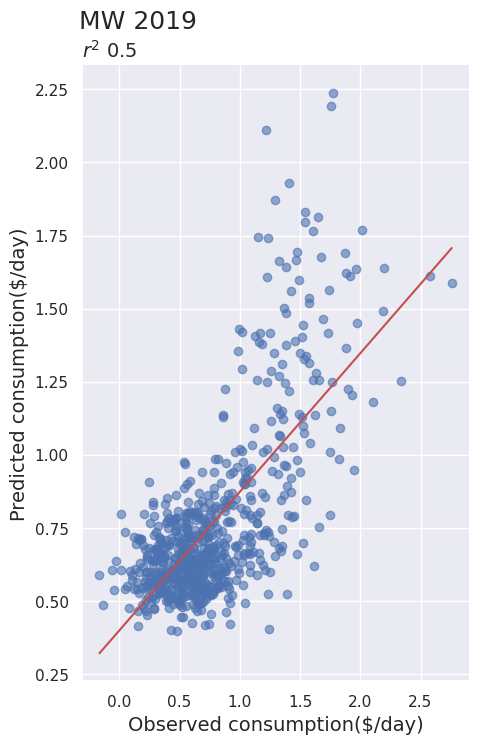

In [19]:
for country in tqdm(countries):
    cnn_osm2(complete_df, Ridge, country, alpha = best_params[country]["alpha"])

In [ ]:
best_scores, best_params = optimize_params(complete_df, CatBoostRegressor(), params={'max_depth': max_depth, 'n_estimators': n_estimators}, seed=1)

In [ ]:
models = cnn_osm(complete_df, XGBRegressor, best_params)


In [ ]:
for country in tqdm(countries):
    cnn_osm2(complete_df, CatBoostRegressor, country, task_type="GPU")


## Rural vs. Urban

In [ ]:
def rural_urban(complete):    
    types = ["rural", "urban"]
    types_r2 = {}
    rural = []
    ys = []
    y_preds = []
    # get features
    for type in types:    
        r2s = []
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            year_df = year_df.loc[year_df.rural == type]
            rural += year_df.rural.values.tolist()
            cnn_X = np.array([np.array(x) for x in year_df["features"].values])
            osm_X = year_df[all_cols].values
            tmp_X = np.hstack((cnn_X, osm_X))
            y_ = year_df["cons_pc"].values

            if X is None:
                X = tmp_X
            else:
                X = np.vstack((X, tmp_X))
            if y is None:
                y = y_
            else:
                y = np.append(y, y_)

        y = np.log(y)
        ys += y.tolist()
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        r, y_hest, _ = eu.run_ridge(X, y, alpha=1000)
        y_preds += y_hest.tolist()
        r2s.append(r)
        types_r2[type] = r2s

    # for the plot
    plt_df = pd.DataFrame.from_dict({"y": ys, "y_pred": y_preds, "rural": rural})

    x_col = "y"
    y_col = "y_pred"
    hue_col = "rural"

    penguins = plt_df
    g = sns.jointplot(data=penguins, x=x_col, y=y_col, hue=hue_col)
    
    for _, gr in penguins.groupby(hue_col):
        sns.regplot(x=x_col, y=y_col, data=gr, scatter=False, ax=g.ax_joint, truncate=False)
    print(types_r2)
    g.ax_joint.set_xlabel("Observed nominal consumption($/day)")
    g.ax_joint.set_ylabel("Predicted nominal consumption($/day)")
    plt.text(-0.8, 1, fr"$r^2 = {round(types_r2['rural'][0], 2)}$", c="#4c72b0")
    plt.text(-0.8, 0.8, fr"$r^2 = {round(types_r2['urban'][0], 2)}$", c="#dd8452")
    plt.legend([],[], frameon=False)
    g.ax_joint.get_legend().remove()
    g.ax_joint.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=g.ax_joint.transAxes)
    plt.savefig("../figs/rural_urban_pop.pdf", dpi=600, bbox_inches="tight")


In [ ]:
rural_urban(complete_df)

## Predict % of poorest people in dataset

In [ ]:
def pooled_features_perc(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []
        for i in tqdm(np.linspace(0.1,1,91)):
            perc_df = complete.loc[complete.cons_pc <= complete.cons_pc.quantile(i)]
            countries = ["NG", "ETH" ,"TZA", "MW"]
            X = None
            y = None
            for i, country in enumerate(countries):
                tmp_df = perc_df.loc[perc_df.country == country]
                years = tmp_df.groupby(["year"]).groups.keys()
                year = max(years)
                year_df = tmp_df.loc[tmp_df.year == year]
                if feature == "CNN":
                    tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                elif feature == "OSM":
                    tmp_X = year_df[all_cols].values
                else:
                    cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                    osm_X = year_df[all_cols].values
                    tmp_X = np.hstack((cnn_X, osm_X))
                    
                y_ = year_df["cons_pc"].values

                if X is None:
                    X = tmp_X
                else:
                    X = np.vstack((X, tmp_X))
                
                if y is None:
                    y = y_
                else:
                    y = np.append(y, y_)

            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r, _, _ = eu.run_ridge(X, y, alpha=1000)
            r2s.append(r)
        feature_r2[feature] = r2s
    
    colors = ["#2a9d8f", "#e9c46a", "#e76f51"]
    for i, feature in enumerate(feature_r2):
        plt.plot(np.linspace(0.1,1,91)*100, feature_r2[feature], c=colors[i], label=feature)
    
    plt.xlabel("Poorest percent of cluster used")
    plt.ylabel(r"$r^2$")
    plt.legend()
    ax = plt.gca()
    ax.text(-0.1, 1.1, string.ascii_uppercase[1], size=20, weight='bold', transform=ax.transAxes)
    plt.savefig("../figs/pooled_percentile.pdf", dpi=600, bbox_inches="tight")
    plt.show()

In [ ]:
pooled_features_perc(complete_df)

## Predicting performance from each feature alone and combined

In [ ]:
def prediction_features_performance(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []        
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            if feature == "CNN":
                tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                tmp_X = StandardScaler().fit_transform(tmp_X)
            elif feature == "OSM":
                tmp_X = year_df[all_cols].values
            else:
                cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                osm_X = year_df[all_cols].values
                tmp_X = np.hstack((cnn_X, osm_X))
                
            y = year_df["cons_pc"].values

            X = tmp_X
           
            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r, _, _ = eu.run_ridge(X, y, alpha=1000)
            r2s.append(r)
            feature_r2[feature] = r2s
            
    feat_df = pd.DataFrame.from_dict(feature_r2)
    feat_df["country"] = countries
    return feat_df

In [ ]:
prediction_features_performance(complete_df)